# Verification of Data-driven Error Bounds for the Single Pendulum

This file trains an approximate Koopman operator for the single pendulum system. Then, using the simulated data and the data-driven operator, it estimates the error bounds. Last, to verify the accuracy of the error bounds,  it plots them against the actual errors in the measured states, when those are propagated with the data-driven Koopman operator. 

## Import Python Libraries

In [0]:

from numpy import zeros, sin, cos, asarray, dot, empty, amax, ones, concatenate, linspace, arange
from random import seed, uniform
from scipy import linalg, io
from math import pi
from scipy.integrate import odeint
from scipy.io import loadmat, savemat
from matplotlib.pyplot import *
from scipy.special import factorial

## Simulation Parameters
This code is set up to train a Koopman operator for the cart pendulum system for three choices of basis functions, using one, two, and three 3 derivatives of the pendulum angle θ. 

The user is encouraged to experiment with different number of derivatives $NKoopman \in [2,4]$, different values for Samples, time spacings between state measurements $ts$ and the time horizon prediction $tFinal$. 


In [0]:
Samples = 5000 # Number of random initial conditions for both training and testing data
ts = 0.02 # time spacing between training state measurements
tFinal = 0.3 # time horizon --- used in measuring error

NKoopman = 4 # Number of basis functions (keep inside [2,4])
Nstates = 2 # Number of system states
Ncontrol = 1 # Number of system inputs

timeSteps = round(tFinal/ts)+1

####### System parameters
g = 9.81 # gravitational constant
l = 1 # pendulum length

def single_pendulum(y,t, u):
    theta, dtheta = y
    f = asarray([dtheta, g/l * sin(theta) +  u ])
    return f

def Psi_k(s, u): # Evaluates basis functions Ψ(s(t_k))
    theta, dtheta = s
    psi = zeros([NKoopman,1])
    psi[0:2, 0] = s
    if NKoopman >= 3:
        psi[2, 0] = g/l * sin(theta) + u
    if NKoopman >= 4:
        psi[3, 0] = g/l * cos(theta) * dtheta
    return psi

def A_and_G(s_1, s_2, u): # Uses measurements s(t_k) & s(t_{k+1}) to calculate A and G
    A = dot(Psi_k(s_2, u), Psi_k(s_1, u).T)
    G = dot(Psi_k(s_1, u), Psi_k(s_1, u).T)
    return A, G

def new_function_error(n,t): # error bound of an arbitrary function f using its n derivatives at time t 
    total_error = t**(n+1)/factorial(n+1)
    return total_error

## Training Koopman Operator

This code uses the single pendulum dynamics to forward simulate randomly sampled states. It then uses the state measurements $s$ separated in time by $ts$ to generate pairs of basis functions $Ψ(s, u)$ used to train an approximate Koopman operator $\tilde{K}_d$.

In [78]:
seed(1)

# Samples = Number_of_Samples
A = zeros((NKoopman, NKoopman))
G = zeros((NKoopman, NKoopman))

Ps0_list = empty((Samples,NKoopman))
Psi_list = empty((Samples,NKoopman))

for i in range (Samples):

    # Sample states
    th0 = uniform(-2*pi, 2*pi)
    dth0 = uniform(-5, 5)
    s0 = [th0, dth0]
    u10 = uniform(-5, 5)

    # Simulate system forward
    sn = odeint(single_pendulum, s0, [0, ts], args=(u10,))
    sn = sn[-1,:]

    # Evaluate basis functions at t = 0 and t = ts
    Ps0_list[i,:] = Psi_k(s0, u10).T
    Psi_list[i,:] = Psi_k(sn, u10).T

    [Atemp, Gtemp] = A_and_G(s0,sn,u10);
    A = A+Atemp
    G = G+Gtemp

Kd = dot(A,linalg.pinv2(G)) # more accurate than numpy
print("The identified Koopman operator is \n", Kd)

## Measure maximum local (across one time step) errors in Ψ(s_{k+1}) - Kd*Ψ(s_k)
local_errors = empty([Samples, NKoopman])
for i in range(Samples):
    local_errors[i,:] = abs(Psi_list[i,:]- dot(Kd,Ps0_list[i,:]))
max_local_errors = amax(local_errors, axis = 0)
print('Max local errors in theta: %.5f and dtheta: %.5f ' % tuple(max_local_errors[0:2]))

# Save trained Koopman and basis functions measurements used to obtain it
io.savemat('Data - Koopman_and_BasisFunctions.mat', {'Kd' : Kd, 'max_local_errors' : max_local_errors}) # save variables to Matlab file

The identified Koopman operator is 
 [[ 9.99999995e-01  1.99999977e-02  1.99952356e-04  1.33256131e-06]
 [-9.45540332e-07  9.99999454e-01  1.99905052e-02  1.99853537e-04]
 [-1.41628008e-04 -1.13283201e-04  9.98575120e-01  1.99731472e-02]
 [-1.41164295e-02 -1.77087638e-02 -1.42611972e-01  9.96309854e-01]]
Max local errors in theta: 0.00000 and dtheta: 0.00028 


## Prediction Error Using Data-Driven Koopman Operator

This code uses the trained Koopman operator $\tilde{K}_d$ to forward propagate randomly sampled states $s$. It also forward propagates the same initial states using the true nonlinear dynamics and measures the inaccuracy of the Koopman propagation in the form of error trajectories over the time window $tFinal$ for each state $s$ for each random sample. 

In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Load learned Koopman operator
KoopmanOperators = loadmat('Data - Koopman_and_BasisFunctions.mat', squeeze_me=True)
Kd = KoopmanOperators['Kd']

# Initialize variable to store error in states over time horizon for each sample
error_history = empty((timeSteps, Samples, Nstates))

for random_i in range(0, Samples):

    # Generate random initial conditions for states and controls
    th0 = uniform(-2*pi, 2*pi)
    dth0 = uniform(-5, 5)
    u10 = uniform(-5, 5)

    s0 = [th0, dth0]
    Psi = Psi_k(s0, u10) # evaluate basis functions at t = 0

    s_Koopman = empty((timeSteps, Nstates)) # store state trajectories
    s_Koopman[0,:] = Psi[0:Nstates].T

    tt = linspace(0,tFinal, timeSteps)

    for i in range(1, timeSteps):
        Psi = dot(Kd,Psi) # Propagate with Koopman: Ψ_{k+1} = K_d * Ψ_k
        s_Koopman[i,:] = Psi[0:Nstates].T

    # Real dynamics evolution
    tt = linspace(0,tFinal, timeSteps)
    s_real = odeint(single_pendulum, s0, tt, args=(u10,))

    # Errors
    for i in range(Nstates):
        error_history[:,random_i, i] = abs(s_real[:,i] - s_Koopman[:,i])

error_history = amax(error_history, axis = 1)
savemat('Data - Errors.mat', {'error_history' : error_history}) # save variables to Matlab file

## Verification of Data-Driven Error Bounds 

This code uses the training set that produced the Koopman operator $\tilde{K}_d$ to estimate the error bounds, which assume a Taylor-based structure in the Koopman operator $\tilde{K}_d$. Then, the error bounds are plotted against the maximum error (across all random samples) for each state, when the latter are propagated with the Koopman operator. 

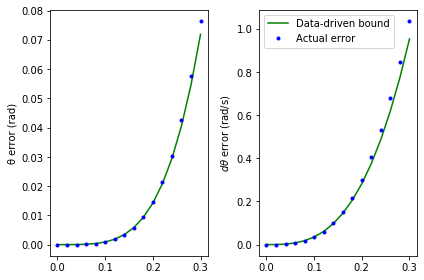

In [80]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

####### 1. Calculate error bounds
mat1 = loadmat('Data - Koopman_and_BasisFunctions.mat', squeeze_me=True)
max_local_errors = mat1['max_local_errors']

nn = arange(NKoopman-1, NKoopman-3, -1) # excludes NKoopman-3
coeff = ts**(nn+1) / factorial(nn+1)
MaxDer = max_local_errors[0:Nstates]/coeff # max magnitude of derivatives

E_bound = empty((timeSteps-1, Nstates))

# % Mvalues = [51.8451; 51.8865];
t = ts
for t_k in range(timeSteps-1):
    for states in range(Nstates):
        E_bound[t_k, states] = MaxDer[states] * new_function_error(nn[states],t)
    t += ts

E_bound= concatenate((zeros((1,Nstates)), E_bound), axis = 0) # add 0 error for t = 0

data = loadmat('Data - Errors.mat', squeeze_me=True)
E = data['error_history']

####### 2. Compare via plotting calculated error bounds with actual errors
time = arange(0, tFinal+ts, ts) # create time vector
ylabels = ['θ error (rad)', '$dθ$ error (rad/s)']
for states in range(Nstates):
    subplot('12'+str(states+1))
    plot(time, E_bound[:,states], 'g') # Verification of data bound from data
    plot(time, E[:,states], 'b.'); # actual error
    ylabel(ylabels[states])

tight_layout()
gca().legend(('Data-driven bound', 'Actual error'))
show(block=False)